## CNN Experiments (10-fold cross validation)

This script for CNN experiments on rescue detection

## Imports

In [1]:
### imports (1) ##
import pandas as pd
import numpy as pn
from numpy import mean

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

import string

import collections
from collections import Counter

### imports (2) ##
from string import punctuation
from os import listdir
from numpy import array

from pickle import load
from numpy import array

### imports (3) ##
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))

### imports (4) ##
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate

import pickle

%matplotlib inline

/home/wkhal001/envs/Twitter_crisis/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.4.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


## Utils

In [2]:
##################################################
#### functions to convert labels to numerical ####
##################################################
def class2Index(classList,class2index):
    return [class2index[c] for c in classList]


def train_classes(classes):
    class2index = {}
    index2class = {}
    classCount = 0
    for cl in np.unique(classes):
        if cl not in class2index:
            class2index[cl] = classCount
            index2class[classCount] = cl
            classCount += 1
            
    return class2index,index2class

In [1]:
##################################################
#### functions to clean the corpus ###############
##################################################
def remove_punc(text): 
    text = "".join([char for char in text if char not in string.punctuation ])
    #text = re.sub('[0-9]+', '', text)
    return text

def tokenization(text):
    text = re.split('\W+',text)
    return text

def remove_url(text):
    text = re.sub(r'http\S+', '', text)
    return(text)

def lower_case(text):
    text = text.lower()
    return(text)

def remove_stopwords(text):
    text = [word for word in text if word not in STOPWORDS]
    return text


def clean_text(text): 
    # lower case
    text_lower = lower_case(text)
    
    # remove puntuation
    text_punc = remove_punc(text_lower) 
    
    #remove URLS
    text_url = remove_url(text_punc)
    
    # tokenization
    text_tokens = tokenization(text_url)
    
    # remove stop words
    no_stop_tokens = remove_stopwords(text_tokens)
    
    return no_stop_tokens

In [2]:
########################################################################################################
#########  function to clean and tokenize a corpus (to create a vocab given a corpus)  #################
###        input: corpus         output: clean tokens ##################################################
########################################################################################################
def clean_corpus(corpus):
    # convert all to lower case 
    corpus_lower = lower_case(corpus)
    
    # remove punctuation
    corpus_punc = remove_punc(corpus_lower) 
    # remove punctuation from each token
    #table = str.maketrans('', '', string.punctuation)
    #tokens = [w.translate(table) for w in tokens]
    
    #remove URLS
    corpus_url = remove_url(corpus_punc)
    
    # tokenization
    corpus_tokens = tokenization(corpus_url)
    # split into tokens by white space
    #tokens = corpus.split()
    
    # remove stop words
    no_stop_tokens = remove_stopwords(corpus_tokens)
    # filter out stop words
    # stop_words = set(stopwords.words('english'))
    # tokens = [w for w in tokens if not w in stop_words]
    
    # remove remaining tokens that are not alphabetic
    #tokens = [word for word in tokens if word.isalpha()]
    
    # filter out short tokens
    final_tokens = [word for word in no_stop_tokens if len(word) > 1]

    return final_tokens

########################################################################################################
#########  function to clean and tokenize a document based on a given vocabulary   #####################
###        input: document         output: clean document's tokens #####################################
########################################################################################################
def clean_document_vocab(doc, vocab):
    # convert to lower case 
    doc_lower = lower_case(doc)
    
    # remove punctuation
    doc_punc = remove_punc(doc_lower) 

    #remove URLS
    doc_url = remove_url(doc_punc)
    
    # tokenization
    doc_tokens = tokenization(doc_url)
    
    # remove stop words
    doc_no_stop_tokens = remove_stopwords(doc_tokens)
    
    # filter out tokens not in vocab
    tokens = [w for w in doc_no_stop_tokens if w in vocab]
    
    #tokens = ' '.join(tokens)
    return tokens


## Load Ian/Ida data set

In [3]:
####################################################
#### read mixed data - verified ####################
####################################################
import pandas as pd

path_to_mixed_verif = '/home/wkhal001/Desktop/Mixed_data_verified/Mixed_data__ian_ida_verified.csv'

mixed_ida_ian_verified=pd.read_csv(path_to_mixed_verif) 

In [6]:
mixed_ida_ian_verified.columns

Index(['Id', 'event', 'text', 'label'], dtype='object')

In [7]:
mixed_ida_ian_verified['label'].value_counts()

0    4935
1     225
Name: label, dtype: int64

In [8]:
Data_mixed = mixed_ida_ian_verified[['text','label']]

In [10]:
Data_mixed['cleaned_tweet'] = Data_mixed['text'].apply(lambda x: " ".join(clean_text(x)))

/home/wkhal001/envs/Twitter_crisis/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [12]:
## Extract useful columns 
df_training = Data_mixed[['text','cleaned_tweet','label']]

In [13]:
df_training.columns= ['non_cleaned_text','text','label']

## Vocabulary and tokenization

In [15]:
##################################################################################
# Create a vocabulary   (specify the corpus data frame (e.g., labeledDF) #########
##################################################################################
corpus = ''
for i in range(len(df_training)) :
    st = df_training.iloc[i]["non_cleaned_text"]
    corpus = corpus + " " + st
    
#corpus
T = clean_corpus(corpus)

### count vocabulary with collection counter ####
vocab = Counter()
vocab.update(T)

print('Vocabulary created...',len(vocab),' tokens')


Vocabulary created... 11721  tokens


## Upload Pretrained word embedding models

In [16]:
##################################################################################
########      Load pretrained embedding    #######################################
##################################################################################
path_to_glove = '/home/wkhal001/Desktop/gensim-data/glove-twitter-200/glove-twitter-200.txt' 
    
# Load the file content in a dictionary
embeddings_index = {}
with open(path_to_glove) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))
#embeddings_index['hurricane']

Found 1193515 word vectors.


In [17]:
#######################################################
###### create Keras tokenizer and fit text ############
#######################################################
tokenizer = Tokenizer(num_words=None,oov_token='OOV')
tokenizer.fit_on_texts(df_training['text'])
vocab_size = len(tokenizer.word_index) + 1
print('Tokenizer vocabulary size ...',vocab_size)

Tokenizer vocabulary size ... 11748


In [18]:
##################################################################################
########      Initialize the embedding layer    ##################################
##################################################################################
EMBEDDING_DIM=200
vocabulary_size=len(tokenizer.word_index)+1
print('Vocaublary size:',vocabulary_size)
print('Embedding dimension:',EMBEDDING_DIM)
print('Create embedding matrix in progress....')
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print('Embedding matrix created')
print('Embedding matrix size',len(embedding_matrix))
print('\n')

Vocaublary size: 11748
Embedding dimension: 200
Create embedding matrix in progress....
Embedding matrix created
Embedding matrix size 11748




## Define CNN architecture

In [19]:
##########################################################################
# Define encoder architecture Kim model  #################################
##########################################################################
def create_kim_encoder(length, vocab_size=100, embedding=False, embed_params={}):
    ## inputs #####
    inputs1 = Input(shape=(length,))
    
    ## Create the embedding layer  ######################################
    if embedding == True:   
        embedding_layer = Embedding(embed_params['Tokenizer_size'] + 1,
                            embed_params['EMBEDDING_DIM'],
                            weights=[embed_params['weights']],
                            input_length=embed_params['input_length'],
                            trainable=False)
        embedding1 = embedding_layer(inputs1)
    else: 
        embedding1 = Embedding(vocab_size, 100)(inputs1)
    

    # channel 1
    #embedding1 = Embedding(vocab_size, 100)(inputs1)
    embedding1 = embedding_layer(inputs1)
    conv1 = Conv1D(filters=32, kernel_size=3, activation='relu')(embedding1)
    #drop1 = Dropout(0.3)(conv1)
    pool1 = MaxPooling1D(pool_size=8)(conv1)
    flat1 = Flatten()(pool1)

    # channel 2
    #inputs2 = Input(shape=(length,))
    #embedding2 = Embedding(vocab_size, 100)(inputs1)
    embedding2 = embedding_layer(inputs1)
    conv2 = Conv1D(filters=1024, kernel_size=4, activation='relu')(embedding2)
    #drop2 = Dropout(0.3)(conv2)
    pool2 = MaxPooling1D(pool_size=8)(conv2)
    flat2 = Flatten()(pool2)

    # channel 3
    #inputs3 = Input(shape=(length,))
    #embedding3 = Embedding(vocab_size, 100)(inputs1)
    embedding3 = embedding_layer(inputs1)
    conv3 = Conv1D(filters=128, kernel_size=16, activation='relu')(embedding3)
    #drop3 = Dropout(0.3)(conv3)
    pool3 = MaxPooling1D(pool_size=6)(conv3)
    flat3 = Flatten()(pool3)
    
    # merge
    union = concatenate([flat1, flat2, flat3])
    #union = union.reshape(union.size(0), -1)
    
    # interpretation
    #dense1 = Dense(300, activation='relu')(merged)
    #outputs = Dense(1, activation='sigmoid')(dense1)
    model = keras.Model(inputs=inputs1, outputs=union) #[inputs1, inputs2, inputs3]

    # summarize
    #print(model.summary())
    #plot_model(model, show_shapes=True, to_file='MMD_kim_encoder_kernel_3_4_8.png')
  
    return model

##########################################################################
# Define encoder architecture single channel  ############################
##########################################################################
def create_single_channel_cnn_encoder(length, vocab_size=100):
    # channel 1
    inputs1 = Input(shape=(length,))

    # channel 1
    #embedding1 = embedding_layer(vocab_size, 100)(inputs1)
    embedding1 = embedding_layer(inputs1)
    conv1 = Conv1D(filters=128, kernel_size=8, activation='relu')(embedding1)
    drop1 = Dropout(0.5)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    
    flat1 = Flatten()(pool1)
    model = keras.Model(inputs=inputs1, outputs=flat1) #[inputs1, inputs2, inputs3] outputs=union

    # summarize
    print(model.summary())
    plot_model(model, show_shapes=True, to_file='MMD_single_channel_encoder_kernel_8.png')
  
    return model

In [20]:
##########################################################################
###  Create a classifier on top of the CNN architectures #################
##########################################################################
def create_classifier(encoder, trainable=True):
    num_classes=2
    input_shape = (128,)
    hidden_units = 512
    
    for layer in encoder.layers:
        layer.trainable = trainable
        
    
    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    features = layers.Dropout(0.3)(features)
    features = layers.Dense(hidden_units, activation="relu")(features)
    #features = layers.Dropout(dropout_rate)(features)
    #features = layers.Dense(50, activation="relu")(features)
    #features = layers.Dropout(dropout_rate)(features)
    outputs = layers.Dense(num_classes, activation="softmax")(features)
    
    # inputs = keras.Input(shape=input_shape)
    # features = encoder(inputs)
    # features = layers.Dropout(dropout_rate)(features)
    # features = layers.Dense(hidden_units, activation="relu")(features)
    # features = layers.Dropout(dropout_rate)(features)
    # outputs = layers.Dense(num_classes, activation="softmax")(features)

    model = keras.Model(inputs=inputs, outputs=outputs, name="cnn-glove-classifier-harvey")
    return model


## 10-fold cross validation

In [21]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

from transformers import AdamW
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from Baseline_Models import Display_metrics,Display_classification_report,Confusion_matrix

import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score

# specify GPU
device = torch.device("cuda")
device

device(type='cuda')

In [22]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
%matplotlib inline

import numpy as np
from sklearn.metrics import average_precision_score


In [23]:
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=2018)

X = df_training['text']
TX = np.array(X.tolist())

Y = df_training['label']
TY= np.array(Y.tolist())

print(skf)

StratifiedKFold(n_splits=10, random_state=2018, shuffle=True)


In [24]:
from keras.models import load_model
 
rep_fold = 1
padd_len = 128
ls_save_results = []

pos_proba_ls = []
y_tests_ls = []
preds_ls = []

################################################
######### Classifier parameters ################
################################################
learning_rate = 0.001
batch_size = 32
hidden_units = 256
num_epochs = 50
dropout_rate = 0.3
num_classes = 2
################################################
################################################
################################################

for train_index, test_index in skf.split(TX,TY):
    print('--------- Fold ',str(rep_fold),'-------------------------')
    print('Length train index....',len(train_index))
    print('Length test index....',len(test_index))
    
    #### training/testing data ########################################
    X_train, X_test = TX[train_index], TX[test_index]
    y_train, y_test = TY[train_index], TY[test_index]
    
    Train_X_cv, val_X, Train_Y_cv, val_Y = train_test_split(X_train,y_train, 
                                                            random_state=2018, 
                                                            test_size=0.1,
                                                            stratify=y_train)
        
    ####### check distribution of positive samples on each fold ######
    count_test = (y_test == 1).sum()
    count_train = (Train_Y_cv == 1).sum()
    count_val = (val_Y == 1).sum()
    print('postive samples in train......',count_train)
    print('postive samples in validation......',count_val)
    print('postive samples in test......',count_test)
    print('------------------------------------------')
    ###################################################################
    
    train_documents = list()
    for row in Train_X_cv: 
        tweet =  row   #row["text"]
        tokens = clean_document_vocab(tweet, vocab)
        train_documents.append(tokens)
    print('cleaned train docs (in tokens) loaded....')
    max_length1 = max([len(s) for s in train_documents])
    print('train max....',max_length1)
    
    validation_documents = list()
    for row in val_X: 
        tweet =  row   #row["text"]
        tokens = clean_document_vocab(tweet, vocab)
        validation_documents.append(tokens)
    print('cleaned validation docs (in tokens) loaded....')
    max_length1 = max([len(s) for s in validation_documents])
    print('train max....',max_length1)
    
    test_documents = list()
    for row in X_test: 
        tweet =  row   #row["text"]
        tokens = clean_document_vocab(tweet, vocab)
        test_documents.append(tokens)
    print('cleaned test docs (in tokens) loaded....')
    max_length1 = max([len(s) for s in test_documents])
    print('test max....',max_length1)
    
    # covert input text to sequence of indices
    train_encoded_docs = tokenizer.texts_to_sequences(train_documents)
    val_encoded_docs = tokenizer.texts_to_sequences(validation_documents)
    test_encoded_docs = tokenizer.texts_to_sequences(test_documents)

    Xtrain = pad_sequences(train_encoded_docs, maxlen=padd_len, padding='post')
    Xval = pad_sequences(val_encoded_docs, maxlen=padd_len, padding='post')
    Xtest = pad_sequences(test_encoded_docs, maxlen=padd_len, padding='post')

    train_labels = Train_Y_cv.tolist()
    dev_labels = val_Y.tolist()
    test_labels = y_test.tolist()

    ###################################################################
    ############## Create CNN model in Keras ##########################
    ###################################################################
    embed_params={'EMBEDDING_DIM':EMBEDDING_DIM,'Tokenizer_size':len(tokenizer.word_index),'weights':embedding_matrix,'input_length':128}
    encoder = create_kim_encoder(128, vocab_size,True,embed_params)
    classifier = create_classifier(encoder)
    classifier.summary()
    
    ###################################################################
    ############## Train CNN model  ###################################
    ###################################################################
    training_padded = np.array(Xtrain)
    training_labels = np.array(train_labels)

    validation_padded = np.array(Xval)
    validation_labels = np.array(dev_labels)
    
    testing_padded = np.array(Xtest)
    testing_labels = np.array(test_labels)

    # compile classifier
    classifier.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )

    ###### Save model ####################################
    model_name = 'f_cnn_ian_ida_fold'+ str(rep_fold) + '.h5'

    # Load the model
    classifier = load_model(model_name)
    #classifier.save(model_name)
    ######################################################
    
    ###################################################################
    ############## Predict using CNN model  ###########################
    ###################################################################
    print('calculate preds....')
    predictions = classifier.predict(testing_padded)
    preds = np.argmax(predictions, axis=1)
    
    dict_r = classification_report(y_test.tolist(), preds, output_dict = True)

    ### calculate probs for precision-recall curve calculation ######
    pos_probs = predictions[:, 1]
    pos_proba_ls.append(pos_probs)
    y_tests_ls.append(y_test.tolist())
    preds_ls.append(preds)
    #################################################################
    
    ###### calculate precision-recall curve and metric #########
    _fold_AP = average_precision_score(y_test.tolist(),pos_probs)
    print("AP score for class 1 --->",_fold_AP)
    ############################################################
    
    
    ### calculate results ####################################
    _f1 = dict_r['1']['f1-score']
    _recall = dict_r['1']['recall']
    _precision = dict_r['1']['precision']
    ##########################################################

    print('f1-score......',_f1)
    print('recall......',_recall)
    print('recall......',_precision)
    
    fold_results = {'report':dict_r,'f1':_f1,'recall':_recall,'precision':_precision,'AP':_fold_AP,'AP_list':pos_probs,'ytest':y_test.tolist()}
    ls_save_results.append(fold_results)


    rep_fold = rep_fold + 1
    print('------------------------------------------------------')
    

--------- Fold  1 -------------------------
Length train index.... 4644
Length test index.... 516
postive samples in train...... 182
postive samples in validation...... 20
postive samples in test...... 23
------------------------------------------
cleaned train docs (in tokens) loaded....
train max.... 77
cleaned validation docs (in tokens) loaded....
train max.... 44
cleaned test docs (in tokens) loaded....
test max.... 33
Model: "cnn-glove-classifier-harvey"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 model (Functional)          (None, 18144)             3598784   
                                                                 
 dropout (Dropout)           (None, 18144)             0         
                                                                 
 dense 

In [26]:
f1_scores =[]
recall_scores = []
precision_scores = []
AP_scores =[]

for i in ls_save_results:
    AP_scores.append(i['AP'])
    f1_scores.append(i['report']['1']['f1-score'])
    recall_scores.append(i['report']['1']['recall'])
    precision_scores.append(i['report']['1']['precision'])
    

In [27]:
import statistics

print('----------------  CNN - 10-cv results (IAN/IDA)----------------')
print('average AP',statistics.mean(AP_scores))
print('stdev AP',statistics.stdev(AP_scores))
print('\n')
print('average F1',statistics.mean(f1_scores))
print('stdev F1',statistics.stdev(f1_scores))
print('\n')
print('average recall',statistics.mean(recall_scores))
print('stdev recall',statistics.stdev(recall_scores))
print('\n')
print('average precision',statistics.mean(precision_scores))
print('stdev precision',statistics.stdev(precision_scores))
print('\n')
print('-----------------------------------------------------')


----------------  CNN - 10-cv results (IAN/IDA)----------------
average AP 0.9291472242280041
stdev AP 0.03446108924069376


average F1 0.8485240288950615
stdev F1 0.05088664986746529


average recall 0.799604743083004
stdev recall 0.07455481028152039


average precision 0.9112187088274044
stdev precision 0.07419165261388087


-----------------------------------------------------


In [28]:
pos_proba_arr = np.concatenate(pos_proba_ls)
pos_y_test_arr = np.concatenate(y_tests_ls)
pos_preds_arr = np.concatenate(preds_ls)

In [29]:
np.savetxt("cnn_probs_ian_ida_best_model.txt",pos_proba_arr)
np.savetxt("cnn_y_test_ian_ida_best_model.txt",pos_y_test_arr)
np.savetxt("cnn_preds_ian_ida_best_model.txt",pos_preds_arr)

In [1]:
## Load saved data in text files ##
# Function to load a list from a text file
def load_list_from_file(file_path):
    with open(file_path, 'r') as file:
        # Read lines and strip newline characters
        items = [float(line.strip()) for line in file]
    return items

# Specify the path to your text file
file_path_probs = 'cnn_probs_ian_ida_best_model.txt'
file_path_preds = 'cnn_preds_ian_ida_best_model.txt'
file_path_y = 'cnn_y_test_ian_ida_best_model.txt'

# Load the list
probs_cnn = load_list_from_file(file_path_probs)
preds_cnn = load_list_from_file(file_path_preds)
ytest_cnn = load_list_from_file(file_path_y)


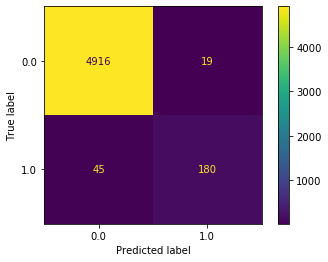

In [4]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
%matplotlib inline

cm = confusion_matrix(ytest_cnn, preds_cnn, labels=np.unique(ytest_cnn))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(ytest_cnn))
disp.plot()

In [5]:
disp.figure_.savefig('confusion_matrix_cnn_ian_ida_final.png')

In [2]:
# with open('cnn_probs_ian_ida_best_model.pkl', 'wb') as f:
#     pickle.dump(pos_proba_arr, f)
    
# with open('cnn_y_test_ian_ida_best_model.pkl', 'wb') as f:
#     pickle.dump(pos_y_test_arr, f)
    

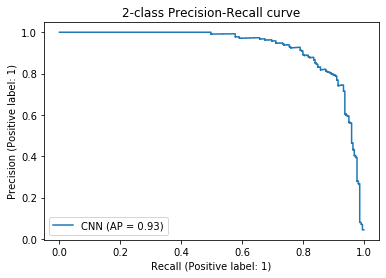

In [31]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
%matplotlib inline

#pos_proba_ls 
#y_tests_ls 
pos_proba_arr = np.concatenate(pos_proba_ls)
y_tests_arr = np.concatenate(y_tests_ls)

###### calculate precision-recall curve and metric #########
precision, recall, thresholds = precision_recall_curve(y_tests_arr,pos_proba_arr)

display = PrecisionRecallDisplay.from_predictions(y_tests_arr, pos_proba_arr, name="CNN")
_ = display.ax_.set_title("2-class Precision-Recall curve")
